# Encoder Decoder

## Set up

In [262]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

PyTorch version: 2.1.1+cu121


In [263]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [264]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 50
BATCH_SIZE: int = 16

### Defining classes and printing on random element from each class

In [265]:
resources_folder = 'resources/classification'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

loaded numpy bitmaps, 8 classes


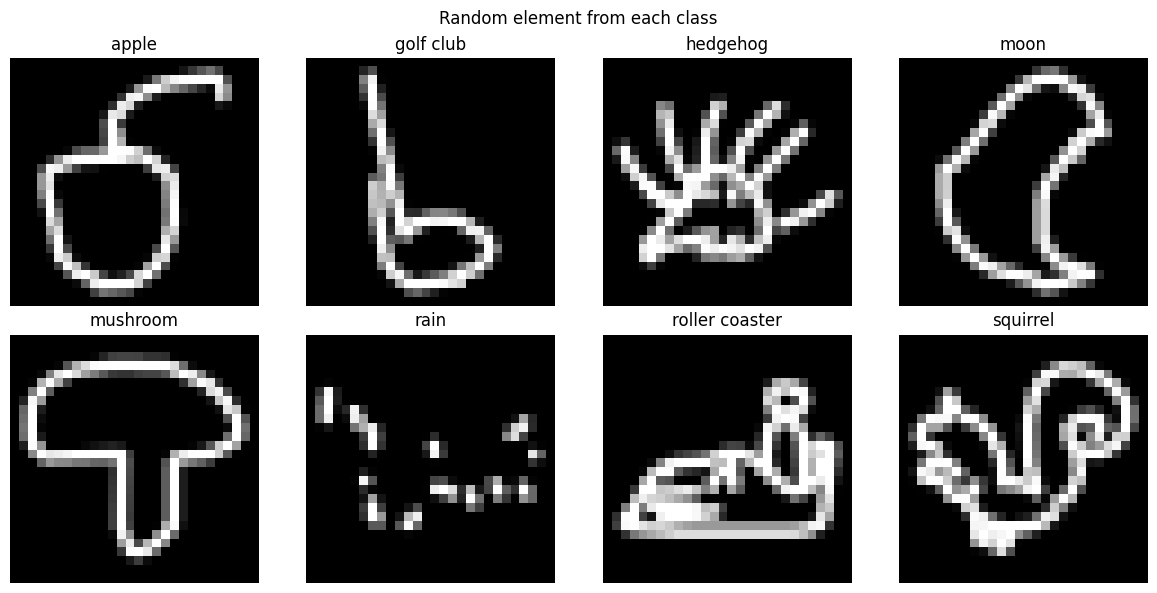

In [266]:
to_plot = []

for class_data in data:
    array = random.choice(class_data).reshape(WIDTH, HEIGHT)
    to_plot.append(array)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(classes[i])

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

### Model definition

In [267]:
class Autoencoder(nn.Module):
    def __init__(self, layer_sizes=[WIDTH * HEIGHT, 128, 64, 32]):
        super(Autoencoder, self).__init__()
        self.architecture = layer_sizes
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Add encoder layers
        for i in range(len(layer_sizes) - 1):
            self.encoder.add_module(f"encoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                self.encoder.add_module(f"encoder_relu_{i}", nn.ReLU())
                self.encoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))
                self.encoder.add_module(f"encoder_batchnorm_{i}", nn.BatchNorm1d(layer_sizes[i+1]))

        # Add decoder layers
        for i in range(len(layer_sizes) - 1, 0, -1):
            self.decoder.add_module(f"decoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i-1]))
            if i > 1:
                self.decoder.add_module(f"decoder_relu_{i}", nn.ReLU())
                self.encoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))
                self.encoder.add_module(f"encoder_batchnorm_{i}", nn.BatchNorm1d(layer_sizes[i+1]))

        self.decoder.add_module("decoder_sigmoid", nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

    def print_model(self):
        print(self.encoder)
        print(self.decoder)

## Try with simple model

In [268]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT // 3]
autoencoder_model = Autoencoder(architecture_1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [269]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / architecture_1[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=261, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=261, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 3.003831417624521


### Dataset creation

In [270]:
from dataset_creation.DataManager import DataManager

split = 0.8
data_manager = DataManager()

training_data, training_labels, validation_data, validation_labels = data_manager.split_data(split, data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')

training dataset size : 927239
validation dataset size : 231814


In [271]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

In [272]:
from dataset_creation.GraysacleDataset import GrayscaleDataset

len_subset = 4000

training_set = GrayscaleDataset(data=shuffled_training_data[:len_subset], labels=shuffled_training_labels[:len_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)
validation_set = GrayscaleDataset(data=shuffled_validation_data[:len_subset], labels=shuffled_validation_labels[:len_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)

### Model training

In [273]:
def train_autoencoder(autoencoder_model, train_loader: DataLoader, valid_loader: DataLoader, criterion, optimizer, num_epochs, batch_size):
    train_psnr_values = []
    train_ssim_values = []

    test_psnr_values = []
    test_ssim_values = []

    train_loss_values = []
    test_loss_values = []

    for epoch in range(num_epochs):
        # Train by batch of images
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            _, decoded = autoencoder_model.forward(inputs)
            loss = criterion(input=decoded, target=inputs)

            # Backward pass
            loss.backward()
            optimizer.step()

        # Train loss
        train_loss_values.append(loss.item())

        # loop on validation to compute validation loss
        for data in valid_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            
            # Forward pass
            _, decoded = autoencoder_model.forward(inputs)
            loss = criterion(input=decoded, target=inputs)

        test_loss_values.append(loss.item())


        # Calculate PSNR and SSIM for train and test sets
        train_psnr = 0
        train_ssim = 0
        test_psnr = 0
        test_ssim = 0

        nb_train_images = 0
        nb_valid_images = 0

        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            for i in range(inputs.size(0)):
                nb_train_images+=1
                img_as_tensor = inputs[i]

                _, decoded = autoencoder_model(img_as_tensor)

                image_matrix = img_as_tensor.cpu().detach().numpy()
                decoded_matrix = decoded.cpu().detach().numpy()

                train_psnr += psnr(image_matrix, decoded_matrix)
                train_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        for data in valid_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            for i in range(inputs.size(0)):
                nb_valid_images+=1
                img_as_tensor = inputs[i]

                _, decoded = autoencoder_model(img_as_tensor)

                image_matrix = img_as_tensor.cpu().detach().numpy()
                decoded_matrix = decoded.cpu().detach().numpy()

                test_psnr += psnr(image_matrix, decoded_matrix)
                test_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        train_psnr /= nb_train_images
        train_ssim /= nb_train_images
        test_psnr /= nb_valid_images
        test_ssim /= nb_valid_images

        train_psnr_values.append(train_psnr)
        train_ssim_values.append(train_ssim)
        test_psnr_values.append(test_psnr)
        test_ssim_values.append(test_ssim)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_values[-1]:.4f}, Test Loss {test_loss_values[-1]:.4f}, ', end = "")
        print(f'Train PSNR: {train_psnr:.4f}, Train SSIM: {train_ssim:.4f}, Test PSNR: {test_psnr:.4f}, Test SSIM: {test_ssim:.4f}')

    return train_loss_values, test_loss_values, train_psnr_values, train_ssim_values, test_psnr_values, test_ssim_values

In [274]:
# Call the function
num_epochs = 50
train_loss_values, test_loss_values, train_psnr_values, train_ssim_values, test_psnr_values, test_ssim_values \
    = train_autoencoder(autoencoder_model, training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs, BATCH_SIZE)
    

Epoch [1/50], Loss: 0.0894, Test Loss 0.1008, Train PSNR: 10.3278, Train SSIM: 0.1592, Test PSNR: 10.3265, Test SSIM: 0.1477
Epoch [2/50], Loss: 0.0944, Test Loss 0.0895, Train PSNR: 10.8769, Train SSIM: 0.1933, Test PSNR: 10.7829, Test SSIM: 0.1749
Epoch [3/50], Loss: 0.0716, Test Loss 0.0886, Train PSNR: 11.4968, Train SSIM: 0.1872, Test PSNR: 11.2553, Test SSIM: 0.1629
Epoch [4/50], Loss: 0.0711, Test Loss 0.0762, Train PSNR: 12.0010, Train SSIM: 0.2022, Test PSNR: 11.6201, Test SSIM: 0.1718
Epoch [5/50], Loss: 0.0645, Test Loss 0.0704, Train PSNR: 12.4776, Train SSIM: 0.2371, Test PSNR: 11.9355, Test SSIM: 0.1971
Epoch [6/50], Loss: 0.0605, Test Loss 0.0681, Train PSNR: 12.9528, Train SSIM: 0.2601, Test PSNR: 12.1924, Test SSIM: 0.2109
Epoch [7/50], Loss: 0.0520, Test Loss 0.0662, Train PSNR: 13.4080, Train SSIM: 0.2908, Test PSNR: 12.4395, Test SSIM: 0.2314
Epoch [8/50], Loss: 0.0471, Test Loss 0.0498, Train PSNR: 13.8117, Train SSIM: 0.3137, Test PSNR: 12.6236, Test SSIM: 0.2469


In [275]:
# Define a function to plot Train and Test Loss, PSNR and SSIM values
def plot_psnr_ssim(train_loss_values, test_loss_values, train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].plot(train_loss_values, label='Train Loss')
    axes[0].plot(test_loss_values, label='Test Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_psnr_values, label='Train PSNR')
    axes[1].plot(test_psnr_values, label='Test PSNR')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('PSNR')
    axes[1].legend()

    axes[2].plot(train_ssim_values, label='Train SSIM')
    axes[2].plot(test_ssim_values, label='Test SSIM')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('SSIM')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


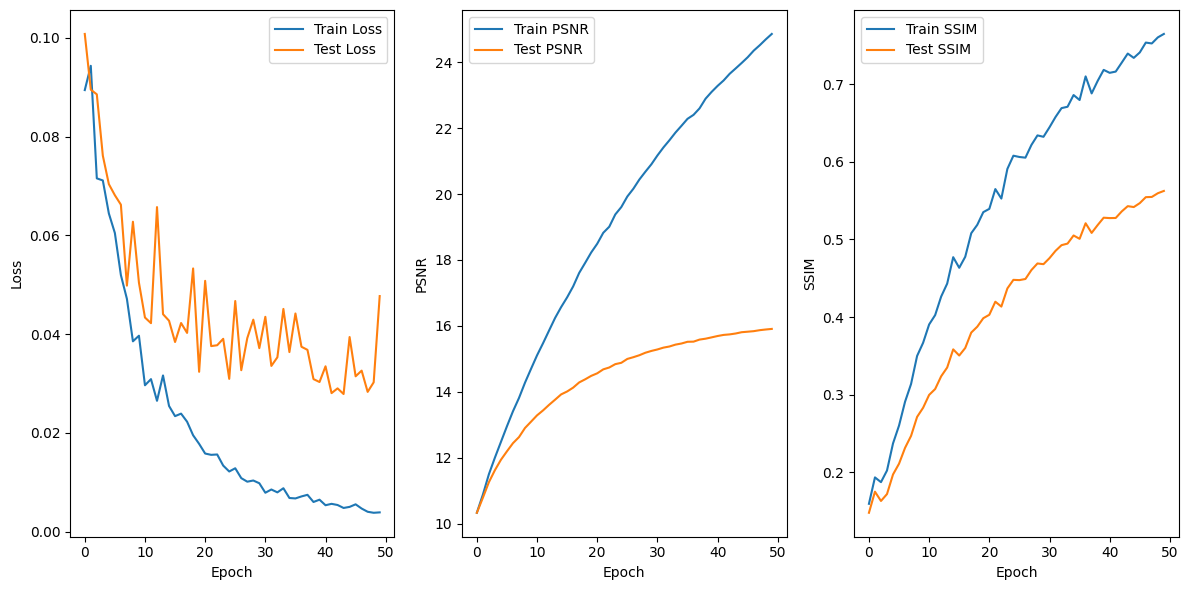

In [276]:
# Call the function
plot_psnr_ssim(train_loss_values, test_loss_values, train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values)

In [277]:
# Define a function to show original and reconstructed images
def show_images(train_images, train_labels, autoencoder_model):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    for i in range(num_cols // 2):
        # Train images
        index = random.randint(0, len(train_images))

        axes[0, i].imshow(train_images[index], cmap='gray')
        axes[0, i].set_title(f"Train original {train_labels[index]}")
        axes[0, i].axis('off')

        # Reconstructed images
        encoded, decoded = autoencoder_model(train_torch_images[index].view(-1, WIDTH * HEIGHT))
        decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

        axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
        axes[1, i].set_title(f"Train reconstructed {train_labels[index]}")
        axes[1, i].axis('off')
    
    for i in range(num_cols // 2, num_cols):
        # Test images
        index = random.randint(0, len(test_images))

        axes[0, i].imshow(test_images[index], cmap='gray')
        axes[0, i].set_title(f"Test original, {test_labels[index]}")
        axes[0, i].axis('off')

        # Reconstructed images
        encoded, decoded = autoencoder_model(test_torch_images[index].view(-1, WIDTH * HEIGHT))
        decoded = decoded.view(-1, HEIGHT, WIDTH)

        axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
        axes[1, i].set_title(f"Test reconstructed {test_labels[index]}")
        axes[1, i].axis('off')


    plt.show()

In [278]:
# Call the function
show_images(train_images, train_labels, autoencoder_model)

NameError: name 'train_images' is not defined

In [ ]:
# Show image with the lowest psnr then ssim in the test set
def return_lowest_image_index_psnr_ssim(test_images, autoencoder_model):
    lowest_psnr = 100
    lowest_ssim = 100
    lowest_psnr_index = 0
    lowest_ssim_index = 0

    for i in range(len(test_images)):
        encoded, decoded = autoencoder_model(test_torch_images[i].view(-1, WIDTH * HEIGHT))
        decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

        image_matrix = test_images[i] / 255.0
        decoded_matrix = decoded.cpu().detach().numpy()[0]

        psnr_value = psnr(image_matrix, decoded_matrix)
        ssim_value = ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())
        
        if psnr_value < lowest_psnr:
            lowest_psnr = psnr_value
            lowest_psnr_index = i

        if ssim_value < lowest_ssim:
            lowest_ssim = ssim_value
            lowest_ssim_index = i

    return [lowest_psnr_index, lowest_psnr], [lowest_ssim_index, lowest_ssim]

lowest_psnr, lowest_ssim = return_lowest_image_index_psnr_ssim(test_images, autoencoder_model)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

In [ ]:
# Show image with the lowest psnr and ssim compared to their original the test set on same plot
def show_lowest_psnr_ssim_image(test_images, autoencoder_model, lowest_psnr, lowest_ssim):
    lowest_psnr_index, psnr  = lowest_psnr
    psnr_image_label = test_labels[lowest_psnr_index]

    lowest_ssim_index, ssim  = lowest_ssim
    ssim_image_label = test_labels[lowest_ssim_index]

    fig, axes = plt.subplots(2, 2, figsize=(7, 6))

    # PSNR image
    axes[0, 0].imshow(test_images[lowest_psnr_index], cmap='gray')
    axes[0, 0].set_title("Original : " + psnr_image_label)
    axes[0, 0].axis('off')

    encoded, decoded = autoencoder_model(test_torch_images[lowest_psnr_index].view(-1, WIDTH * HEIGHT))
    decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

    axes[0, 1].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
    axes[0, 1].set_title(f"Reconstructed : {psnr_image_label}, PSNR: {psnr:.4f}")
    axes[0, 1].axis('off')

    # SSIM image
    axes[1, 0].imshow(test_images[lowest_ssim_index], cmap='gray')
    axes[1, 0].set_title("Original : " + ssim_image_label)
    axes[1, 0].axis('off')

    encoded, decoded = autoencoder_model(test_torch_images[lowest_ssim_index].view(-1, WIDTH * HEIGHT))
    decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

    axes[1, 1].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
    axes[1, 1].set_title(f"Reconstructed : {ssim_image_label}, SSIM: {ssim:.4f}")
    axes[1, 1].axis('off')

    plt.show()


# Call the function
show_lowest_psnr_ssim_image(test_images, autoencoder_model, lowest_psnr, lowest_ssim)

## Try with a different model architecture

In [ ]:
#layers = [WIDTH * HEIGHT, WIDTH * HEIGHT // ]
autocoder_2 = Autoencoder().to(device)

# Define loss function and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autocoder_2.parameters(), lr=0.001)

# Print architecture
autocoder_2.print_model()

# Compression factor
print(f'Compression factor: {WIDTH * HEIGHT / autocoder_2.architecture[-1]}')

In [ ]:
# Call the function
num_epochs = 50
batch_size = 32

train_loss_values, test_loss_values, train_psnr_values, train_ssim_values, test_psnr_values, test_ssim_values \
    = train_autoencoder(autocoder_2, train_torch_images, test_torch_images, criterion, optimizer, num_epochs, batch_size)

In [ ]:
plot_psnr_ssim(train_loss_values, test_loss_values, train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values)

In [ ]:
show_images(train_images, train_labels, autocoder_2)

In [ ]:
lowest_psnr, lowest_ssim = return_lowest_image_index_psnr_ssim(test_images, autocoder_2)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

show_lowest_psnr_ssim_image(test_images, autocoder_2, lowest_psnr, lowest_ssim)

## Try with resnet18 architecture

In [ ]:
# Use pretrained model

# Load pretrained model

pretrained_model = models.resnet18(pretrained=True)
pretrained_model = pretrained_model.to(device)

# Print pretrained model architecture
print(pretrained_model)

# Freeze all layers

for param in pretrained_model.parameters():
    param.requires_grad = False

# Add custom layers

pretrained_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, nb_classes)
)

# Print new model architecture
print(pretrained_model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)


In [ ]:
# Define a function to train the model
def train_pretained_model():
    